# ADA 2018 -  “Happiness” Share it through music.

#### Andres Montero, Ariel Alba, Diego Iriarte




In [1]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import os.path
import ast
import seaborn as sns

from helpers import *
from datetime import datetime, date, time
from scipy import stats

%load_ext autoreload
%autoreload 2


In [2]:
# Constants
DATA_DIR = './data/'
MUSIC_DIR = '{dir}{file}/'.format(dir=DATA_DIR, 
                                  file='fma_metadata')
PKL_DIR = '{dir}{file}/'.format(dir=DATA_DIR, 
                               file='pkl')

# True if we want to to execute the clean phase and to force 
# saving the cleaned file
CLEAN_PHASE = True
DEBUG = True


In [3]:
if CLEAN_PHASE:
    echonest_path = '{dir}{file}'.format(dir=MUSIC_DIR, 
                                         file='echonest.csv')
    features_path = '{dir}{file}'.format(dir=MUSIC_DIR,
                                         file='features.csv')
    genres_path = '{dir}{file}'.format(dir=MUSIC_DIR,
                                       file='genres.csv')
    tracks_path = '{dir}{file}'.format(dir=MUSIC_DIR,
                                       file='tracks.csv')
    

In [4]:
if CLEAN_PHASE:
    # Load datasets into pandas dataframes
    echonest_col_names=['track_id','danceability','energy',
                        'artist_latitude','artist_longitude',
                        'artist_name','artist_discovery',
                        'artist_family','artist_hotness',
                        'song_currency','song_hotness']
    
    echonest_dtypes = {'track_id': int, 'danceability': float, 
                       'energy': float, 'artist_latitude': float, 
                       'artist_longitude': float, 'artist_name': str,
                       'artist_discovery': float, 'artist_family': float,
                       'artist_hotness': float, 'song_currency': float,
                       'song_hotness': float}
    
    echonest_df = pd.read_csv(echonest_path, names=echonest_col_names,
                              header=3, dtype=echonest_dtypes, 
                              usecols=[0,2,3,11,13,14,21,22,23,24,25])

    genres_dtypes = {'genre_id': int, '#tracks': int, 
                     'parent': int, 'top_level': int}
    
    genres_df = pd.read_csv(genres_path, dtype=genres_dtypes)
    
    track_col_names = ['track_id', 'album_date_created',
                       'album_date_released', 'album_id',
                       'album_listens', 'album_title', 'artist_id',
                       'artist_name', 'track_duration', 'track_genre_top',
                       'track_language', 'track_listens', 'track_tags', 
                       'track_title']

    tracks_dtypes = {'track_id': int, 'album_date_created': str,
                     'album_date_released': str, 
                     'album_id': int, 'album_listens': int, 
                     'album_title': str, 'artist_id': int,
                     'artist_name': str, 'track_duration': int, 
                     'track_genre_top': str, 'track_language': str,
                     'track_listens': int, 'track_tags': str, 
                     'track_title': str}

    tracks_df = pd.read_csv(tracks_path, names=track_col_names,
                            header=2, usecols=[0, 2, 3, 6, 8, 11,
                                               21, 26, 38, 40, 45, 
                                               47, 51, 52])


In [5]:
# Echonest clean phase 
if CLEAN_PHASE:
    # Get city, state, country from artist longitude and latitude
    cities=[]
    states=[]
    countries=[]
    
    for i in range (0, len(echonest_df)):
        if np.isnan(echonest_df.artist_latitude[i]):
            city = np.nan
            state = np.nan
            country = np.nan
        else:
            coordinates = (echonest_df.artist_latitude[i], 
                           echonest_df.artist_longitude[i])
            results = rg.search(coordinates, mode=1)
            city = results[0]['name']
            state = results[0]['admin1']
            country = results[0]['cc']
        
        cities.append(city)
        states.append(state)
        countries.append(country)
    
    echonest_df.insert(loc=5, column='city', 
                       value=pd.Series(cities))
    echonest_df.insert(loc=6, column='state',
                       value=pd.Series(states))
    echonest_df.insert(loc=7, column='country', 
                       value=pd.Series(countries))
    

Loading formatted geocoded file...


In [6]:
# Tracks clean phase
if CLEAN_PHASE:
    # Transforms str to datetime
    tracks_df['album_date_released'] = pd.to_datetime( \
                                            tracks_df['album_date_released'])
    tracks_df['album_date_created'] = pd.to_datetime( \
                                            tracks_df['album_date_created'])
    # Transform str to list
    tracks_df['track_tags'] = tracks_df['track_tags'].apply(lambda x: ast.literal_eval(x))


In [35]:
if CLEAN_PHASE:
    # Normalize dataframes to take out redundancy
    # Select main columns to create new df
    artists_df = tracks_df[['artist_id', 'artist_name']].copy()

    albums_df = tracks_df[['album_id', 'album_date_created', 'album_date_released',
                           'album_title', 'album_listens']].copy()

    # Drop duplicates
    artists_df = artists_df.drop_duplicates('artist_id')
    albums_df = albums_df.drop_duplicates('album_id')
    
    # Join echonist data to artist
    echonest_tracks = echonest_df.merge(tracks_df, left_on='track_id', 
                                        right_on='track_id')
    
    print(echonest_tracks.describe())
    

            track_id  danceability        energy  artist_latitude  \
count   13129.000000  13129.000000  13129.000000      9770.000000   
mean    34031.058268      0.487290      0.537516        39.961892   
std     28950.422182      0.190148      0.278049        15.554275   
min         2.000000      0.051307      0.000020       -45.867100   
25%     12986.000000      0.344759      0.321300        37.784827   
50%     28097.000000      0.485635      0.549113        40.781400   
75%     45021.000000      0.629094      0.776254        47.254575   
max    124911.000000      0.968645      0.999964        68.927500   

       artist_longitude  artist_discovery  artist_family  artist_hotness  \
count       9770.000000      13129.000000   13129.000000    13129.000000   
mean         -49.984040          0.321996       0.286287        0.346769   
std           59.377974          0.114619       0.128304        0.133279   
min         -155.434000          0.000000       0.000000        0.000000  

In [8]:
print('Artists size: {}'.format(len(artists_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(artists_df.isna().sum(axis=0)))
artists_df.head()


Artists size: 16341

NaN count by column:
artist_id      0
artist_name    0
dtype: int64


,artist_id,artist_name
0,1,AWOL
3,6,Kurt Vile
4,4,Nicky Cook
10,52,Abominog
12,53,Airway


In [9]:
albums_df.head()

,album_id,album_date_created,album_date_released,album_title,album_listens
0,1,2008-11-26 01:44:45,2009-01-05,AWOL - A Way Of Life,6073
3,6,2008-11-26 01:45:08,2008-02-06,Constant Hitmaker,47632
4,4,2008-11-26 01:45:05,2009-01-06,Niris,2710
10,58,2008-11-26 01:49:19,2009-01-07,mp3,3331
12,59,2008-11-26 01:49:35,2006-12-01,Live at LACE,1681


In [10]:
echonest_df

,track_id,danceability,energy,artist_latitude,artist_longitude,city,state,country,artist_name,artist_discovery,artist_family,artist_hotness,song_currency,song_hotness
0,2,0.675894,0.634476,32.6783,-83.22300,Jeffersonville,Georgia,US,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
1,3,0.528643,0.817461,32.6783,-83.22300,Jeffersonville,Georgia,US,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
2,5,0.745566,0.701470,32.6783,-83.22300,Jeffersonville,Georgia,US,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
3,10,0.658179,0.924525,39.9523,-75.16240,Philadelphia,Pennsylvania,US,Kurt Vile,0.557339,0.614272,0.798387,0.005158,0.354516
4,134,0.513238,0.560410,32.6783,-83.22300,Jeffersonville,Georgia,US,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
5,139,0.260911,0.607067,41.8239,-71.41200,Providence,Rhode Island,US,Alec K. Redfearn and the Eyesores,0.388923,0.330784,0.406300,0.000250,0.038550
6,140,0.734079,0.265685,41.8239,-71.41200,Providence,Rhode Island,US,Alec K. Redfearn and the Eyesores,0.388923,0.330784,0.406300,0.000000,0.000000
7,141,0.435933,0.075632,41.8239,-71.41200,Providence,Rhode Island,US,Alec K. Redfearn and the Eyesores,0.388923,0.330784,0.406300,0.000167,0.038550
8,142,0.379065,0.823856,41.8239,-71.41200,Providence,Rhode Island,US,Alec K. Redfearn and the Eyesores,0.388923,0.330784,0.406300,0.000125,0.038550
9,144,0.443643,0.641997,41.8239,-71.41200,Providence,Rhode Island,US,Amoebic Ensemble,0.252381,0.238153,0.263657,0.000063,0.038500


In [11]:
# Read  and wirte files depending on the existance of own path
echonest_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                        file='echonest_df.pkl')
genre_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                     file='genres_df.pkl')
tracks_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                      file='tracks_df.pkl')

if not CLEAN_PHASE or os.path.exists(echonest_df_path):
    echonest_df = pd.read_pickle(echonest_df_path)
else:
    echonest_df.to_pickle(echonest_df_path)
    
if not CLEAN_PHASE or os.path.exists(echonest_df_path):
    genres_df = pd.read_pickle(genre_df_path)
else:
    genres_df.to_pickle(genre_df_path)
    
if not CLEAN_PHASE or os.path.exists(tracks_df_path):
    tracks_df = pd.read_pickle(tracks_df_path)
else:
    tracks_df.to_pickle(tracks_df_path)
    

In [12]:
print('Echonest size: {}'.format(len(echonest_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(echonest_df.isna().sum(axis=0)))
echonest_df.head()


Echonest size: 13129

NaN count by column:
track_id               0
danceability           0
energy                 0
artist_latitude     3359
artist_longitude    3359
city                3359
state               3359
country             3359
artist_name            0
artist_discovery       0
artist_family          0
artist_hotness         0
song_currency          0
song_hotness           0
dtype: int64


,track_id,danceability,energy,artist_latitude,artist_longitude,city,state,country,artist_name,artist_discovery,artist_family,artist_hotness,song_currency,song_hotness
0,2,0.675894,0.634476,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
1,3,0.528643,0.817461,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
2,5,0.745566,0.701470,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
3,10,0.658179,0.924525,39.9523,-75.1624,Philadelphia,Pennsylvania,US,Kurt Vile,0.557339,0.614272,0.798387,0.005158,0.354516
4,134,0.513238,0.560410,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000


In [13]:
print('Genres size: {}'.format(len(genres_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(genres_df.isna().sum(axis=0)))
genres_df.head()


Genres size: 163

NaN count by column:
genre_id     0
#tracks      0
parent       0
title        0
top_level    0
dtype: int64


,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5


In [14]:
print('Tracks size: {}'.format(len(tracks_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(tracks_df.isna().sum(axis=0)))
tracks_df.tail()


Tracks size: 106574

NaN count by column:
track_id                   0
album_date_created      3529
album_date_released    36280
album_id                   0
album_listens              0
album_title             1025
artist_id                  0
artist_name                0
track_duration             0
track_genre_top        56976
track_language         91550
track_listens              0
track_tags                 0
track_title                1
dtype: int64


,track_id,album_date_created,album_date_released,album_id,album_listens,album_title,artist_id,artist_name,track_duration,track_genre_top,track_language,track_listens,track_tags,track_title
106569,155316,2017-03-30 15:20:35,2017-02-17,22940,1506,"Live at Monty Hall, 2/17/2017",24357,Spowder,162,Rock,NaN,102,[],The Auger
106570,155317,2017-03-30 15:20:35,2017-02-17,22940,1506,"Live at Monty Hall, 2/17/2017",24357,Spowder,217,Rock,NaN,165,[],Let's Skin Ruby
106571,155318,2017-03-30 15:20:35,2017-02-17,22940,1506,"Live at Monty Hall, 2/17/2017",24357,Spowder,404,Rock,NaN,168,[],My House Smells Like Kim Deal/Pulp
106572,155319,2017-03-30 15:20:35,2017-02-17,22940,1506,"Live at Monty Hall, 2/17/2017",24357,Spowder,146,Rock,NaN,294,[],The Man With Two Mouths
106573,155320,2017-03-26 16:22:18,2017-03-26,22906,7481,What I Tell Myself Vol. 2,21615,Forget the Whale,198,NaN,NaN,705,"['ballad', 'epic', 'rockabilly', 'curse', 'hex...",Another Trick Up My Sleeve (Instrumental)


#### First we will see the top 10 countries were the music is produced.

In [15]:
#Merge data to have the entire data frame
tracks_echonest = pd.merge(echonest_df, tracks_df, left_on='track_id',
                           right_on='track_id', how='right')
tracks_echonest.head()


,track_id,danceability,energy,artist_latitude,artist_longitude,city,state,country,artist_name_x,artist_discovery,...,album_listens,album_title,artist_id,artist_name_y,track_duration,track_genre_top,track_language,track_listens,track_tags,track_title
0,2,0.675894,0.634476,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,6073,AWOL - A Way Of Life,1,AWOL,168,Hip-Hop,en,1293,[],Food
1,3,0.528643,0.817461,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,6073,AWOL - A Way Of Life,1,AWOL,237,Hip-Hop,en,514,[],Electric Ave
2,5,0.745566,0.701470,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,6073,AWOL - A Way Of Life,1,AWOL,206,Hip-Hop,en,1151,[],This World
3,10,0.658179,0.924525,39.9523,-75.1624,Philadelphia,Pennsylvania,US,Kurt Vile,0.557339,...,47632,Constant Hitmaker,6,Kurt Vile,161,Pop,en,50135,[],Freeway
4,134,0.513238,0.560410,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,6073,AWOL - A Way Of Life,1,AWOL,207,Hip-Hop,en,943,[],Street Music


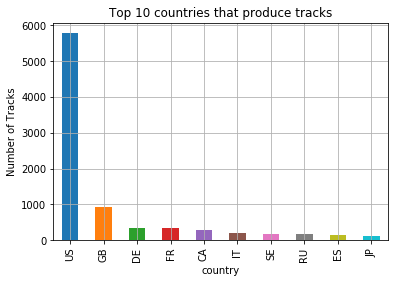

In [16]:
tracks_grouped = tracks_echonest.groupby(tracks_echonest['country']) \
                                .size()
tracks_country_top10 = tracks_grouped.sort_values(ascending=False) \
                                     .head(10)
tracks_country_top10.plot(kind='bar', 
                          title="Top 10 countries that produce tracks")
plt.ylabel('Number of Tracks')
plt.grid()


#### Top 10 albums

In [17]:
tracks_echonest['album_listens'] = tracks_echonest['album_listens'] \
                                     .apply(lambda x : neg_to_zero(x))
# tacks_echonest['album_listens']


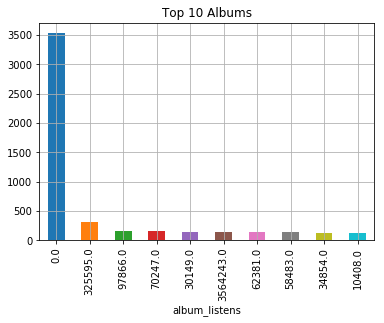

In [18]:
albums = tracks_echonest.groupby(tracks_echonest['album_listens']) \
                        .size()
albums_top10 = albums.sort_values(ascending=False).head(10)
albums_top10.plot(kind='bar', title="Top 10 Albums")
plt.grid()


#### Top 10 Tracks

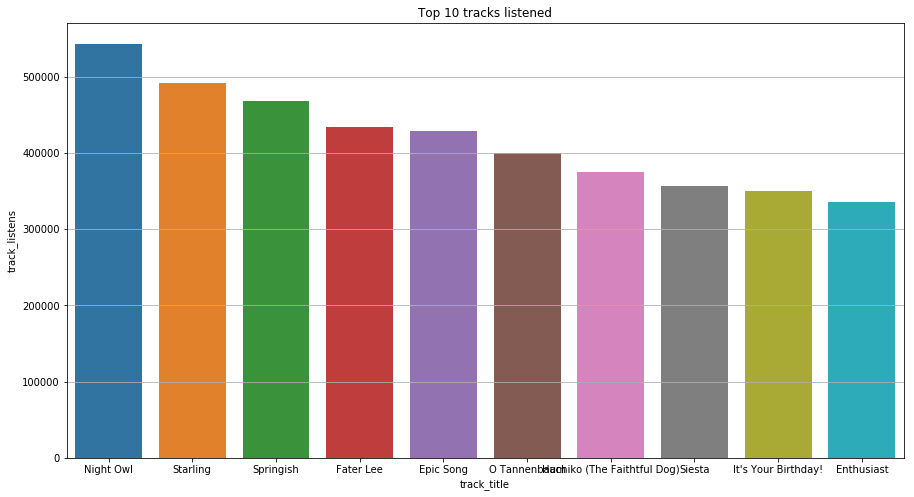

In [19]:
tracks_top10 = tracks_echonest.sort_values(by='track_listens',
                                           ascending=False).head(10)
plt.figure(figsize=(15, 8))
plt.title("Top 10 tracks listened")
plt.grid()
ax = sns.barplot(x='track_title', y= 'track_listens',
                 data=tracks_top10)


#### Relation between danceability and duration of the song

In [20]:
def cat_duration(quantity):
    """Function to clean inventory from raw data

    Args:
        quantity: Raw quantity.
    Returns:
        new_quantity: Official quantity.
    """
    
    if quantity <=2.0:
        return (1.0)
    elif quantity >2.0 & quantity<=4.0:
        return (2.0)
    else:
        return (3.0)


In [21]:
tracks_echonest.insert(loc=23, column='track_duration_minutes',
                       value=(tracks_echonest['track_duration'] / 60))


/anaconda3/envs/ada/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


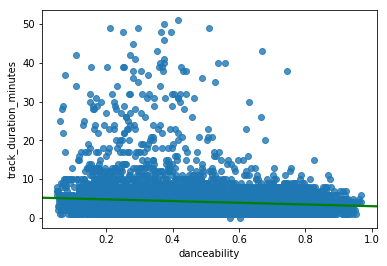

In [22]:
pd.to_numeric(tracks_echonest['track_duration_minutes'])
tracks_echonest['track_duration_minutes'] = tracks_echonest['track_duration_minutes'] \
                                                .apply(lambda x : np.rint(x))
sns.regplot(x='danceability', y='track_duration_minutes',
            data=tracks_echonest, ci=95, 
            line_kws = {'color': 'green'})


In [23]:
tracks_echonest.head()


,track_id,danceability,energy,artist_latitude,artist_longitude,city,state,country,artist_name_x,artist_discovery,...,album_title,artist_id,artist_name_y,track_duration,track_genre_top,track_duration_minutes,track_language,track_listens,track_tags,track_title
0,2,0.675894,0.634476,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,AWOL - A Way Of Life,1,AWOL,168,Hip-Hop,3.0,en,1293,[],Food
1,3,0.528643,0.817461,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,AWOL - A Way Of Life,1,AWOL,237,Hip-Hop,4.0,en,514,[],Electric Ave
2,5,0.745566,0.701470,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,AWOL - A Way Of Life,1,AWOL,206,Hip-Hop,3.0,en,1151,[],This World
3,10,0.658179,0.924525,39.9523,-75.1624,Philadelphia,Pennsylvania,US,Kurt Vile,0.557339,...,Constant Hitmaker,6,Kurt Vile,161,Pop,3.0,en,50135,[],Freeway
4,134,0.513238,0.560410,32.6783,-83.2230,Jeffersonville,Georgia,US,AWOL,0.388990,...,AWOL - A Way Of Life,1,AWOL,207,Hip-Hop,3.0,en,943,[],Street Music


In [24]:
spearman_coeff = stats.spearmanr(tracks_echonest['danceability'], 
                                 tracks_echonest['track_duration_minutes'])
spearman_coeff


SpearmanrResult(correlation=nan, pvalue=nan)

In [25]:
genre_year = tracks_echonest[['track_genre_top', 'album_date_released']]
genre_year.insert(loc=2, column='album_released_year',
                  value=(genre_year['album_date_released'].dt.year))
genre_year.head()


,track_genre_top,album_date_released,album_released_year
0,Hip-Hop,2009-01-05,2009.0
1,Hip-Hop,2009-01-05,2009.0
2,Hip-Hop,2009-01-05,2009.0
3,Pop,2008-02-06,2008.0
4,Hip-Hop,2009-01-05,2009.0


In [26]:
top_genre = genre_year.groupby(genre_year['track_genre_top']).size()

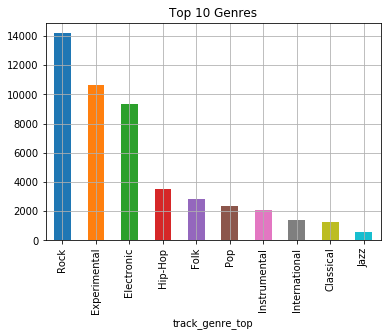

In [27]:
top_genre_sorted = top_genre.sort_values(ascending=False).head(10)
top_genre_sorted.plot(kind='bar', title="Top 10 Genres")
plt.grid()
